In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_validate
from tqdm import tnrange, tqdm_notebook, tqdm
from datetime import timedelta
from datetime import datetime
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as stats
import xgboost as xgb
import requests as r
import pandas as pd
import seaborn as s
import numpy as np
import googlemaps
import postgres
import holidays
import config
import json
import math

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Show all vars
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("stored_queries/combined145.csv")

In [3]:
data.columns = ['dayofservice','tripid','lineid','direction','progrnumber','stopid','plannedDEP','plannedARR','actualDEP','actualARR','routeid']

In [4]:
data.drop_duplicates()

data.dayofservice = pd.to_datetime(data.dayofservice.loc[:])

data = data.sort_values(by=['dayofservice','lineid','tripid','direction','progrnumber'])

data.drop(columns=['lineid','routeid'], inplace=True)

In [5]:
testdata = data.copy()

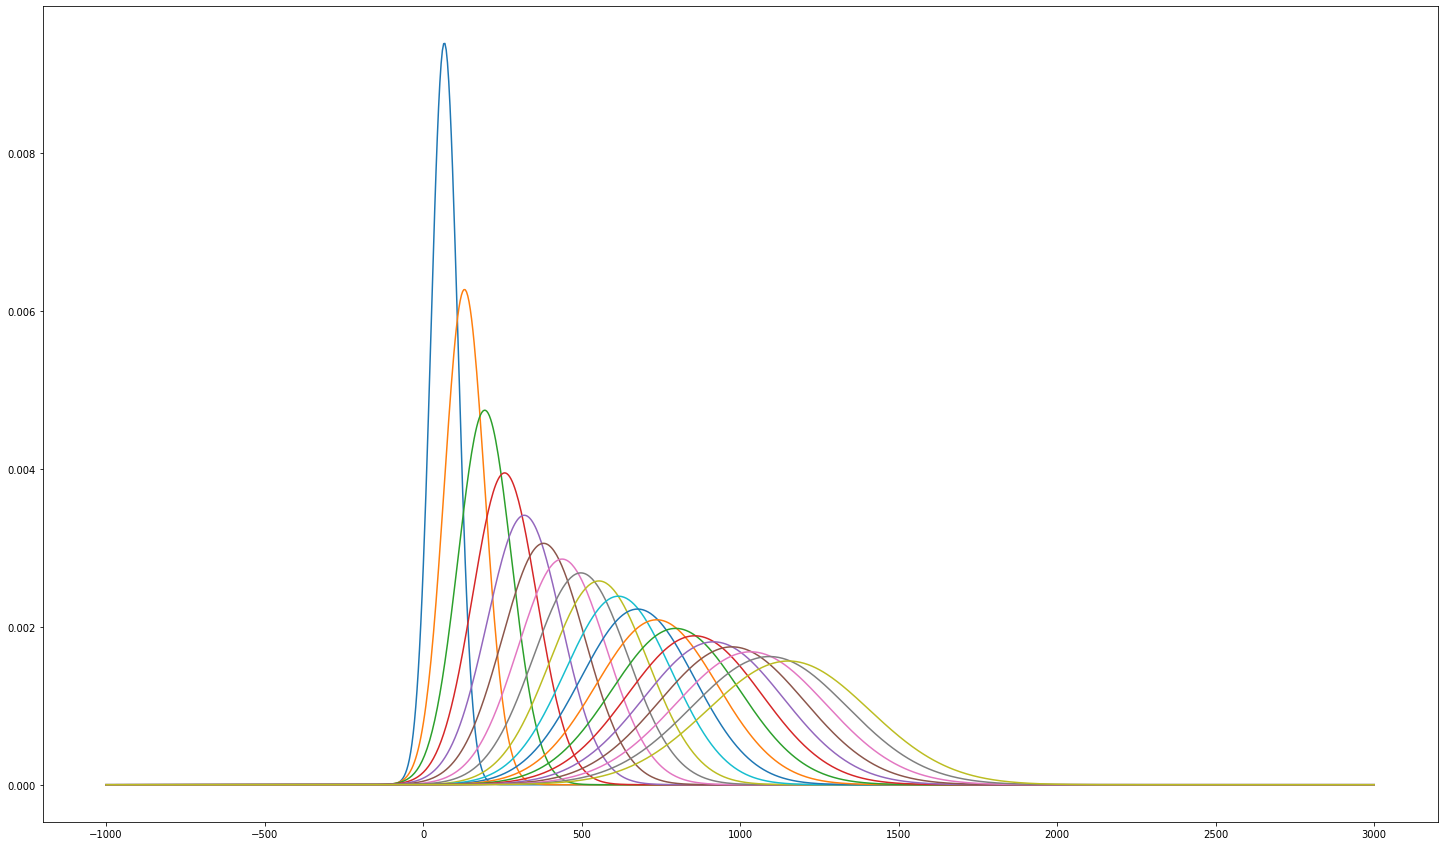

In [63]:
plt.figure(figsize=(15,8))

sigmas = []
mus= []

for prog_diff in tnrange(1,20):
    
    testdata = data.copy()
    
    # previous stopid
    previousstops =  list(testdata.stopid)
    previousstops = np.array(previousstops[:-prog_diff]).astype(int)

    # progrnumber of previous stopid
    previousstops_progrnumber = list(testdata.progrnumber)
    previousstops_progrnumber = np.array(previousstops_progrnumber[:-prog_diff]).astype(int)

    # arrival times of previous stopid
    previousstops_actualARR = list(testdata.actualARR)
    previousstops_actualARR = np.array(previousstops_actualARR[:-prog_diff])

    previousstops_actualDEP = list(testdata.actualDEP)
    previousstops_actualDEP = np.array(previousstops_actualDEP[:-prog_diff])

    previousstops_plannedARR = list(testdata.plannedARR)
    previousstops_plannedARR = np.array(previousstops_plannedARR[:-prog_diff])

    previousstops_plannedDEP = list(testdata.plannedDEP)
    previousstops_plannedDEP = np.array(previousstops_plannedDEP[:-prog_diff])

    # Delete the first row of the dataframe to shift the progrnumbers by one. 
    testdata = testdata.iloc[prog_diff:]

    testdata['previous_stopid'] = previousstops

    testdata['previous_stopARR'] = previousstops_actualARR
    testdata['previous_stopDEP'] = previousstops_actualDEP
    testdata['previous_plannedARR'] = previousstops_plannedARR
    testdata['previous_plannedDEP'] = previousstops_plannedDEP

    testdata['previous_progrnumber'] = previousstops_progrnumber

    testdata = testdata[testdata.progrnumber != prog_diff]
    testdata.dropna(inplace=True);

    # recast type of integer cols from float to int. 
    testdata.previous_stopid = testdata.previous_stopid.astype(int)
    testdata.previous_progrnumber = testdata.previous_progrnumber.astype(int)

    # make progrnumber difference column and then drop anything thats not exactly 1, removes data which skips stops. 
    testdata['progrnumber_difference'] = testdata.progrnumber - testdata.previous_progrnumber

    # remove non-consecutive stop pairs.
    testdata = testdata[testdata.progrnumber_difference==prog_diff]

#     sample = testdata[testdata.plannedARR==32504]
    sample=testdata
    
    sample['arr_diff'] = sample.actualARR - sample.previous_stopARR

    sample = sample[sample.arr_diff > 0]

    # Filter outliers from the dataset [ 2σ as the cutoff ~95% of data ]
    sample = sample[abs(sample.arr_diff - sample.arr_diff.mean()) < 2*sample.arr_diff.std()]
    
    arr_diff = sample.arr_diff
    
    mu, sigma = stats.norm.fit(arr_diff)
    x = np.linspace(-1000, 3000, 1000)
    p = stats.norm.pdf(x, mu, sigma)
    plt.plot(x,p)

    mus.append(mu)
    sigmas.append(sigma)
#     plt.title(f"sigma:{sigma} | mu:{mu}")
#     plt.axvline(x=mu, color='red', linestyle='--')

    
plt.show()

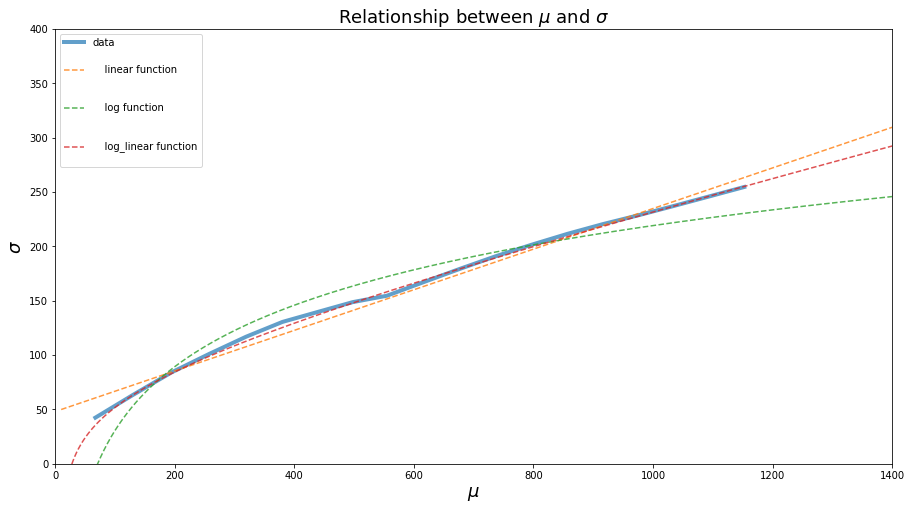

In [88]:
# note plot log, plot linear, plot log linear

from scipy.optimize import curve_fit

def log_linear(x,a,b,c,d):
    """
    log_linear function
    """
    return a*x + b*np.log(c*x) + d

def linear(x,a,b):
    """
    linear function
    """
    return a*x +b 

def log(x,a,b,c):
    """
    log function
    """
    return a*np.log(b*x) + c
    
plt.figure(figsize=(15,8))
plt.plot(mus, sigmas, linewidth=4, alpha=0.7, label='data')
    
for func in [linear,log,log_linear]:
    
    fitting_function = func

    params,c = curve_fit(fitting_function, mus,sigmas)

    
    plt.plot(np.linspace(10,1500, 1000), 
             fitting_function(np.linspace(0,1500,1000),*params), 
             '--', 
             alpha=0.8,
             label=f"{func.__doc__}"
            )

plt.title(r'Relationship between $\mu$ and $\sigma$', fontsize=18)
plt.ylabel(r'$\sigma$', fontsize=18)
plt.xlabel(r'$\mu$', fontsize=18)
plt.ylim([0,400])
plt.xlim([0,1400])
plt.legend()

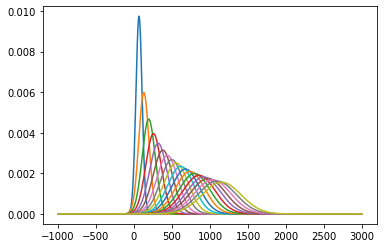

In [67]:
for idx in range(len(mus)):
    
    m = mus[idx]
    s = log_linear(m,*params)
    st=sigmas[idx]
    
    
    x = np.linspace(-1000, 3000, 1000)
    p = stats.norm.pdf(x, m, s)

    plt.plot(x,p)

In [90]:
print("Fitting Function:  \nsigma = {:.2} * mu + {:.2} * log({:.2} * mu) + {:.2}".format(*params))

Fitting Function:  
sigma = 0.13 * mu + 2.6e+01 * log(2.3e-27 * mu) + 1.5e+03


$$
\sigma = 0.13\mu + 2.6* ln\left(\text{ }\mu * \left(2.3*10^{-27} \text{ }\right)\right) + 1.5*10^3
$$